In [1]:
import multiprocess as mp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
from tqdm import tqdm
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import datetime
from sklearn.preprocessing import quantile_transform
pd.options.mode.chained_assignment = None  # default='warn'
import gc
import requests
from urllib.parse import urlparse

In [2]:
basedir = './prepped_data/'

In [3]:
%%time
main_data_df = pd.read_csv(basedir + 'main_data_monthly_converted.csv')
print(main_data_df.shape)
main_data_df.head()

(4441027, 17)
Wall time: 9.67 s


,전월세매매구분,전용면적(㎡),계약일,금액(만원),층,건축년도,가격/면적,년,월,target_log_transformed,target/area_log_transformed,건물종류,지번주소,도로명주소,X좌표,Y좌표,주택가격지수
0,매매,77.75,8,57000.0,2,1988,733.118971,2013,9,10.950807,6.597308,아파트,서울특별시 강남구 개포동 655-2,서울특별시 강남구 언주로 103-0,960473.743425,1.942553e+06,79.100
1,매매,77.75,16,57000.0,2,1988,733.118971,2013,12,10.950807,6.597308,아파트,서울특별시 강남구 개포동 655-2,서울특별시 강남구 언주로 103-0,960473.743425,1.942553e+06,79.213
2,매매,77.75,29,55000.0,7,1988,707.395498,2014,1,10.915088,6.561590,아파트,서울특별시 강남구 개포동 655-2,서울특별시 강남구 언주로 103-0,960473.743425,1.942553e+06,79.451
3,매매,77.75,10,59500.0,4,1988,765.273312,2014,11,10.993732,6.640233,아파트,서울특별시 강남구 개포동 655-2,서울특별시 강남구 언주로 103-0,960473.743425,1.942553e+06,82.100
4,매매,77.75,28,75000.0,5,1988,964.630225,2016,3,11.225243,6.871745,아파트,서울특별시 강남구 개포동 655-2,서울특별시 강남구 언주로 103-0,960473.743425,1.942553e+06,89.466


In [4]:
%%time
land_prices_df = pd.read_csv(basedir + 'land_prices_ver_2.csv')
land_prices_df.shape

Wall time: 941 ms


(1594565, 4)

In [5]:
%%time
land_specs_df = pd.read_csv(basedir + 'land_specs_ver_3.csv')
land_specs_df.shape

Wall time: 2.37 s


(1563645, 11)

In [6]:
%%time
land_plans_df = pd.read_csv(basedir + 'land_plans_ver_3.csv')
land_plans_df.shape

<string>:2: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,27

Wall time: 29.6 s


(1565190, 288)

In [7]:
land_plans_df.fillna('해당사항없음', inplace=True)

In [8]:
%%time
bdinfo_df = pd.read_csv(basedir + 'bdinfo_features_structure_purpose_roof.csv')
bdinfo_df.shape

Wall time: 4.51 s


(1436953, 63)

In [9]:
%%time
bdinfo2_df = pd.read_csv(basedir + 'new_building_features_2021_0209.csv')
print(bdinfo2_df.shape)
bdinfo2_df.head()

(1276270, 22)
Wall time: 2.18 s


,지번주소,기준년도,사용승인년도,총외필지수,대지면적,총건축면적,총연면적,총용적률연면적,총호수,주건축물수,부속건축물수,부속건축물면적,옥내기계식대수,옥외기계식대수,옥내자주식대수,옥외자주식대수,총주차수,epi점수,친환경점수,대장종류,호수대비연면적,호수대비주차수
0,서울특별시 강남구 개포동 1163-4,2013,2013,0.0,336.1,167.78,1102.75,839.39,20.0,1.0,0.0,0.0,0.0,0.0,9.0,0.0,9.0,0.0,0.0,표제부,55.1375,0.45
1,서울특별시 강남구 개포동 1163-4,2014,2013,0.0,336.1,167.78,1102.75,839.39,20.0,1.0,0.0,0.0,0.0,0.0,9.0,0.0,9.0,0.0,0.0,표제부,55.1375,0.45
2,서울특별시 강남구 개포동 1163-4,2015,2013,0.0,336.1,167.78,1102.75,839.39,20.0,1.0,0.0,0.0,0.0,0.0,9.0,0.0,9.0,0.0,0.0,표제부,55.1375,0.45
3,서울특별시 강남구 개포동 1163-4,2016,2013,0.0,336.1,167.78,1102.75,839.39,20.0,1.0,0.0,0.0,0.0,0.0,9.0,0.0,9.0,0.0,0.0,표제부,55.1375,0.45
4,서울특별시 강남구 개포동 1163-4,2017,2013,0.0,336.1,167.78,1102.75,839.39,20.0,1.0,0.0,0.0,0.0,0.0,9.0,0.0,9.0,0.0,0.0,표제부,55.1375,0.45


In [10]:
main_data_df.rename(columns={'전용면적(㎡)':'전용면적'}, inplace=True)

In [11]:
%%time
main_data_df['전용면적_mean'] = main_data_df[['지번주소', '건축년도', '전용면적']].groupby(['지번주소', '건축년도']).transform('mean')['전용면적']
main_data_df['전용면적_min'] = main_data_df[['지번주소', '건축년도', '전용면적']].groupby(['지번주소', '건축년도']).transform('min')['전용면적']
main_data_df['전용면적_max'] = main_data_df[['지번주소', '건축년도', '전용면적']].groupby(['지번주소', '건축년도']).transform('max')['전용면적']

Wall time: 1.66 s


In [12]:
main_data_df['가격/면적'] = main_data_df['금액(만원)'] / main_data_df['전용면적']

In [13]:
main_data_df['건물나이'] = main_data_df['년'] - main_data_df['건축년도']
main_data_df['건물나이'].describe()

count    4.441027e+06
mean     1.366252e+01
std      9.898723e+00
min     -1.200000e+01
25%      5.000000e+00
50%      1.200000e+01
75%      2.000000e+01
max      8.900000e+01
Name: 건물나이, dtype: float64

In [14]:
main_data_df['year_linear'] = (main_data_df['년'] - main_data_df['년'].min()) + ((main_data_df['월']-1)/12)

In [15]:
def month_circular_sine_func(x):
    return math.sin(2*math.pi*((x-1)/12))

def month_circular_cosine_func(x):
    return math.cos(2*math.pi*((x-1)/12))

In [16]:
main_data_df['month_sin'] = main_data_df['월'].apply(month_circular_sine_func)
main_data_df['month_cos'] = main_data_df['월'].apply(month_circular_cosine_func)

In [17]:
main_data_df.drop(columns=['월', '계약일'], inplace=True)

In [18]:
xmax = main_data_df['X좌표'].max()
xmin = main_data_df['X좌표'].min()
ymax = main_data_df['Y좌표'].max()
ymin = main_data_df['Y좌표'].min()

In [19]:
coor_minmax_df = pd.DataFrame({'xmax':xmax, 'xmin':xmin, 'ymax':ymax, 'ymin':ymin}, index=[0])
coor_minmax_df.to_csv('./Training/training_data_ver_16/coor_minmax.csv', index=False)
coor_minmax_df

,xmax,xmin,ymax,ymin
0,971728.508488,938060.786948,1.965830e+06,1.937374e+06


In [20]:
main_data_df['xnorm'] = (main_data_df['X좌표'] - xmin - ((xmax - xmin)/2))
main_data_df['ynorm'] = (main_data_df['Y좌표'] - ymin - ((ymax - ymin)/2))
main_data_df['x_2nd'] = main_data_df['xnorm']**2 / 2
main_data_df['y_2nd'] = main_data_df['ynorm']**2 / 2
main_data_df['x_sin'] = main_data_df['xnorm'].apply(np.sin)
main_data_df['y_sin'] = main_data_df['ynorm'].apply(np.sin)
main_data_df['x_cos'] = main_data_df['xnorm'].apply(np.cos)
main_data_df['y_cos'] = main_data_df['ynorm'].apply(np.cos)
main_data_df['xy'] = main_data_df['xnorm'] * main_data_df['ynorm']

In [21]:
main_data_df.drop(columns=['X좌표', 'Y좌표'], inplace=True)

In [22]:
main_data_df['trade_type'] = main_data_df['건물종류'] + '_' + main_data_df['전월세매매구분']
main_data_df.drop(columns=['건물종류', '전월세매매구분'], inplace=True)

In [23]:
merge1_df = main_data_df.merge(land_prices_df, on=['지번주소', '년'])
merge1_df.shape

(4280322, 30)

In [24]:
merge1_df['공시지가'] = merge1_df['공시지가'] / 10000
merge1_df.rename(columns={'공시지가':'공시지가(만원)'}, inplace=True)

In [25]:
bdinfo_df.drop(columns=['사용승인년도'], inplace=True)
bdinfo_df.rename(columns={'기준년도':'년'}, inplace=True)

In [26]:
merge1_df.shape

(4280322, 30)

In [27]:
merge2_df = merge1_df.merge(bdinfo_df, on=['지번주소', '년'])
merge2_df.shape

(4263837, 90)

In [28]:
%%time
bdinfo3_df = pd.read_csv(basedir + 'extracted_building_features.csv')
bdinfo3_df = bdinfo3_df[['지번주소', '기준년도'] + [col for col in bdinfo3_df.columns if '층' in col]]
print(bdinfo3_df.shape)
bdinfo3_df.head()

(1453497, 6)
Wall time: 20.6 s


,지번주소,기준년도,층min,층max,층mean,층median
0,서울특별시 마포구 서교동 484-16,2006,4.0,4.0,4.0,4.0
1,서울특별시 마포구 서교동 484-16,2007,4.0,4.0,4.0,4.0
2,서울특별시 마포구 서교동 484-16,2008,4.0,4.0,4.0,4.0
3,서울특별시 마포구 서교동 484-16,2009,4.0,4.0,4.0,4.0
4,서울특별시 마포구 서교동 484-16,2010,4.0,4.0,4.0,4.0


In [29]:
bdinfo3_df.rename(columns={'기준년도':'년'}, inplace=True)

In [30]:
bdinfo2_df.head()

,지번주소,기준년도,사용승인년도,총외필지수,대지면적,총건축면적,총연면적,총용적률연면적,총호수,주건축물수,부속건축물수,부속건축물면적,옥내기계식대수,옥외기계식대수,옥내자주식대수,옥외자주식대수,총주차수,epi점수,친환경점수,대장종류,호수대비연면적,호수대비주차수
0,서울특별시 강남구 개포동 1163-4,2013,2013,0.0,336.1,167.78,1102.75,839.39,20.0,1.0,0.0,0.0,0.0,0.0,9.0,0.0,9.0,0.0,0.0,표제부,55.1375,0.45
1,서울특별시 강남구 개포동 1163-4,2014,2013,0.0,336.1,167.78,1102.75,839.39,20.0,1.0,0.0,0.0,0.0,0.0,9.0,0.0,9.0,0.0,0.0,표제부,55.1375,0.45
2,서울특별시 강남구 개포동 1163-4,2015,2013,0.0,336.1,167.78,1102.75,839.39,20.0,1.0,0.0,0.0,0.0,0.0,9.0,0.0,9.0,0.0,0.0,표제부,55.1375,0.45
3,서울특별시 강남구 개포동 1163-4,2016,2013,0.0,336.1,167.78,1102.75,839.39,20.0,1.0,0.0,0.0,0.0,0.0,9.0,0.0,9.0,0.0,0.0,표제부,55.1375,0.45
4,서울특별시 강남구 개포동 1163-4,2017,2013,0.0,336.1,167.78,1102.75,839.39,20.0,1.0,0.0,0.0,0.0,0.0,9.0,0.0,9.0,0.0,0.0,표제부,55.1375,0.45


In [31]:
bdinfo2_df.drop(columns=['사용승인년도', '대장종류'], inplace=True)

In [32]:
bdinfo2_df.rename(columns={'기준년도':'년'}, inplace=True)

In [33]:
to_drop_df = bdinfo2_df[(bdinfo2_df['부속건축물수'] > 0) & (bdinfo2_df['부속건축물면적'] == 0)]
print(to_drop_df.shape)

(675, 20)


In [34]:
bdinfo2_df.drop(to_drop_df.index, inplace=True)

In [35]:
merge2_df = merge2_df.merge(bdinfo2_df, on=['지번주소', '년'])
print(merge2_df.shape)

(3891247, 108)


In [36]:
merge2_df = merge2_df.merge(bdinfo3_df, on=['지번주소', '년'])

In [37]:
merge2_df.head()

,전용면적,금액(만원),층,건축년도,가격/면적,년,target_log_transformed,target/area_log_transformed,지번주소,도로명주소,주택가격지수,전용면적_mean,전용면적_min,전용면적_max,건물나이,year_linear,month_sin,month_cos,xnorm,ynorm,x_2nd,y_2nd,x_sin,y_sin,x_cos,y_cos,xy,trade_type,공시지가(만원),표준지여부,철근콘크리트구조_fraction,철골철근콘크리트구조_fraction,벽돌구조_fraction,프리케스트콘크리트구조_fraction,경량철골구조_fraction,철골콘크리트구조_fraction,일반철골구조_fraction,블록구조_fraction,일반목구조_fraction,기타조적구조_fraction,기타강구조_fraction,강파이프구조_fraction,기타구조_fraction,석구조_fraction,기타콘크리트구조_fraction,라멘조_fraction,조립식판넬조_fraction,주_용도_공동주택_fraction,주_용도_종교시설_fraction,주_용도_제2종근린생활시설_fraction,주_용도_단독주택_fraction,주_용도_제1종근린생활시설_fraction,주_용도_교육연구시설_fraction,주_용도_판매시설_fraction,주_용도_노유자시설_fraction,주_용도_자동차관련시설_fraction,주_용도_업무시설_fraction,주_용도_운동시설_fraction,주_용도_창고시설_fraction,주_용도_문화및집회시설_fraction,주_용도_위락시설_fraction,주_용도_숙박시설_fraction,주_용도_근린생활시설_fraction,주_용도_위험물저장및처리시설_fraction,주_용도_동.식물관련시설_fraction,주_용도_의료시설_fraction,주_용도_공장_fraction,주_용도_관광휴게시설_fraction,주_용도_수련시설_fraction,주_용도_판매및영업시설_fraction,주_용도_교육연구및복지시설_fraction,지붕_평지붕_fraction,지붕_철콘지붕_fraction,지붕_경사지붕_fraction,지붕_기타지붕_fraction,지붕_기와지붕_fraction,지붕_판넬지붕_fraction,지붕_박공지붕_fraction,지붕_모임지붕_fraction,지붕_스페니쉬기와_fraction,지붕_슬레이트지붕_fraction,지붕_초가지붕_fraction,지붕_멘사드지붕_fraction,지붕_철골지붕_fraction,지붕_함석지붕_fraction,지붕_목구조지붕_fraction,지붕_원형지붕_fraction,지붕_금속지붕_fraction,지붕_전통지붕_fraction,지붕_비닐지붕_fraction,총외필지수,대지면적,총건축면적,총연면적,총용적률연면적,총호수,주건축물수,부속건축물수,부속건축물면적,옥내기계식대수,옥외기계식대수,옥내자주식대수,옥외자주식대수,총주차수,epi점수,친환경점수,호수대비연면적,호수대비주차수,층min,층max,층mean,층median
0,77.75,57000.0,2,1988,733.118971,2013,10.950807,6.597308,서울특별시 강남구 개포동 655-2,서울특별시 강남구 언주로 103-0,79.100,77.75,77.75,77.75,25,7.666667,-0.866025,-0.500000,5579.095707,-9048.956121,1.556315e+07,4.094180e+07,-0.364267,-0.920469,0.931294,0.390815,-5.048499e+07,아파트_매매,921.0,N,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,528.17,5321.05,4736.87,54.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98.537963,0.0,9.0,9.0,9.0,9.0
1,77.75,57000.0,2,1988,733.118971,2013,10.950807,6.597308,서울특별시 강남구 개포동 655-2,서울특별시 강남구 언주로 103-0,79.213,77.75,77.75,77.75,25,7.916667,-0.500000,0.866025,5579.095707,-9048.956121,1.556315e+07,4.094180e+07,-0.364267,-0.920469,0.931294,0.390815,-5.048499e+07,아파트_매매,921.0,N,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,528.17,5321.05,4736.87,54.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98.537963,0.0,9.0,9.0,9.0,9.0
2,77.75,35000.0,4,1988,450.160772,2013,10.463103,6.109605,서울특별시 강남구 개포동 655-2,서울특별시 강남구 언주로 103-0,76.652,77.75,77.75,77.75,25,7.000000,0.000000,1.000000,5579.095707,-9048.956121,1.556315e+07,4.094180e+07,-0.364267,-0.920469,0.931294,0.390815,-5.048499e+07,아파트_전세,921.0,N,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,528.17,5321.05,4736.87,54.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98.537963,0.0,9.0,9.0,9.0,9.0
3,77.75,32000.0,9,1988,411.575563,2013,10.373491,6.019993,서울특별시 강남구 개포동 655-2,서울특별시 강남구 언주로 103-0,78.021,77.75,77.75,77.75,25,7.166667,0.866025,0.500000,5579.095707,-9048.956121,1.556315e+07,4.094180e+07,-0.364267,-0.920469,0.931294,0.390815,-5.048499e+07,아파트_전세,921.0,N,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,528.17,5321.05,4736.87,54.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98.537963,0.0,9.0,9.0,9.0,9.0
4,77.75,37000.0,1,1988,475.884244,2013,10.518673,6

In [38]:
merge2_df['최고층-층'] = merge2_df['층max'] - merge2_df['층']
merge2_df['최고층-층'].describe()

count    3.887402e+06
mean     6.342028e+00
std      6.350064e+00
min     -3.000000e+01
25%      2.000000e+00
50%      4.000000e+00
75%      1.000000e+01
max      6.300000e+01
Name: 최고층-층, dtype: float64

In [39]:
negative_df = merge2_df[merge2_df['최고층-층'] < 0]
negative_df.shape

(5495, 113)

In [40]:
negative_df['지번주소'].nunique()

177

In [41]:
idx_to_drop = []
for addr in tqdm(negative_df['지번주소'].unique()):
    addr_df = merge2_df[merge2_df['지번주소'] == addr]
    addr2_df = negative_df[negative_df['지번주소'] == addr]
    min_year = addr2_df['년'].min()
    df_to_drop = addr_df[addr_df['년'] >= min_year]
    for idx in df_to_drop.index:
        idx_to_drop.append(idx)

100%|████████████████████████████████████████████████████████████████████████████████| 177/177 [00:23<00:00,  7.51it/s]


In [42]:
len(list(set(idx_to_drop)))

29939

In [43]:
merge2_df.drop(idx_to_drop, inplace=True)

In [44]:
merge2_df.shape

(3857463, 113)

In [45]:
merge2_df['층norm'] = merge2_df['층'] / merge2_df['층max']

In [46]:
merge2_df['층norm'].describe()

count    3.857463e+06
mean     5.451642e-01
std      2.923374e-01
min     -3.000000e+00
25%      3.333333e-01
50%      5.384615e-01
75%      7.857143e-01
max      1.000000e+00
Name: 층norm, dtype: float64

In [47]:
merge2_df.drop(columns=['최고층-층'], inplace=True)

In [48]:
merge2_df['지하세대있음'] = merge2_df['층'].apply(lambda x: 1 if x < 0 else 0)
merge2_df['지하세대있음'].value_counts()

0    3797325
1      60138
Name: 지하세대있음, dtype: int64

In [49]:
cols = [col for col in land_specs_df.columns if col != '공시지가']
cols

['지번주소',
 '년',
 '지목명',
 '토지면적',
 '용도지역명1',
 '용도지역명2',
 '토지이동상황',
 '지형높이',
 '지형형상',
 '도로접면']

In [50]:
merge2_df = merge2_df.merge(land_specs_df[cols], on=['지번주소', '년'])
merge2_df.shape

(3857459, 122)

In [51]:
merge2_df.drop(columns=['대지면적'], inplace=True)

In [52]:
merge3_df = merge2_df.merge(land_plans_df, on=['지번주소', '년'])
merge3_df.shape

(3857232, 407)

In [53]:
merge3_df.columns = [col.replace(':','').replace('/','').replace('\\','').replace('*','').replace('?','').replace('\"','')\
                     .replace('|','').replace('<','').replace('>','').replace('ㆍ','_').replace(' ','_') for col in merge3_df.columns]

In [54]:
land_plans_df.columns = [col.replace(':','').replace('/','').replace('\\','').replace('*','').replace('?','').replace('\"','')\
                     .replace('|','').replace('<','').replace('>','').replace('ㆍ','_').replace(' ','_') for col in land_plans_df.columns]

In [55]:
lp_catcols = land_plans_df.columns.tolist()[2:]
lp_catcols[:5]

['(한강)오염행위_제한지역', '(한강)폐기물매립시설_설치제한지역', '4대문안', '가로구역별_최고높이_제한지역', '가스공급설비']

In [56]:
ls_catcols = [col for col in cols if col not in ['지번주소', '년', '토지면적']]
ls_catcols

['지목명', '용도지역명1', '용도지역명2', '토지이동상황', '지형높이', '지형형상', '도로접면']

In [57]:
def building_age_feature_engi(x):
    # x is a number
    
    if pd.isna(x) == True:
        return x
    else:
        
        if x < 0:
            return '건축전계약'
        elif x < 5:
            return '5년미만'
        elif x < 10:
            return '10년미만'
        elif x < 15:
            return '15년미만'
        elif x < 20:
            return '20년미만'
        elif x < 30:
            return '30년미만'
        elif x < 40:
            return '40년미만'
        else:
            return '40년이상'

In [58]:
merge3_df = merge3_df[merge3_df['건물나이'] >= 0]
merge3_df.shape

(3857231, 407)

In [59]:
merge3_df['건물나이'] = merge3_df['건물나이'].apply(building_age_feature_engi)
merge3_df['건물나이'].value_counts()

5년미만     792141
30년미만    739099
15년미만    717566
10년미만    703870
20년미만    606871
40년미만    262537
40년이상     35147
Name: 건물나이, dtype: int64

In [60]:
merge3_df.drop(columns=['년', '도로명주소'], inplace=True)

In [61]:
cat_cols = ['trade_type', '표준지여부', '건물나이'] + ls_catcols + lp_catcols

In [62]:
top_22_df = pd.read_csv('Training/training_data_ver_16/shap_top_22.csv', index_col=[0])
print(top_22_df.shape)
top_22_df.head()

(22, 6)


,model_0_shap_summary,model_1_shap_summary,model_2_shap_summary,model_3_shap_summary,model_4_shap_summary,shap_summary_mean
trade_type,93.820917,97.153154,93.304250,93.761785,94.252643,94.458550
토지면적over총연면적times공시지가,71.489308,73.258290,76.002862,72.472447,76.035547,73.851691
year_linear,65.421895,65.083373,66.493716,65.274088,64.053698,65.265354
건축년도,53.396990,53.400304,51.292150,51.734241,50.729348,52.110607
전용면적,40.123015,37.876511,40.318999,38.256690,37.952788,38.905601


In [63]:
merge3_df = merge3_df.drop(columns=['주택가격지수']).dropna()
merge3_df.columns = [col.replace(' ','_').replace('·','_') for col in merge3_df.columns]

In [64]:
#merge3_df = merge3_df[(merge3_df['가격면적'] >= 200) & (merge3_df['가격면적'] <= 3000)]

In [65]:
merge3_df['호수대비부속건축물면적'] = merge3_df['부속건축물면적'] / merge3_df['총호수']

In [66]:
merge3_df = merge3_df[(merge3_df['호수대비부속건축물면적'] < 100)]

In [67]:
merge3_df = merge3_df.reset_index(drop=True)

In [68]:
gc.collect()

66

In [69]:
merge3_df['토지면적over총연면적times공시지가'] = merge3_df['토지면적'] / merge3_df['총연면적'] * merge3_df['공시지가(만원)']

In [70]:
cols_to_log = ['총건축면적', '총연면적', '총용적률연면적', '토지면적', '부속건축물면적']
for col in cols_to_log:
    merge3_df[col] = merge3_df[col].apply(np.log1p)

In [71]:
cat_cols_list = [col.replace(' ','_').replace('·','_') for col in cat_cols]
len(cat_cols_list)

296

In [72]:
cat_cols = [col for col in cat_cols_list if col in top_22_df.index.tolist()]
len(cat_cols)

4

In [74]:
cat_cols

['trade_type', '용도지역명1', '토지이동상황', '아파트지구']

In [73]:
merge3_df.head()

,전용면적,금액(만원),층,건축년도,가격면적,target_log_transformed,targetarea_log_transformed,지번주소,전용면적_mean,전용면적_min,전용면적_max,건물나이,year_linear,month_sin,month_cos,xnorm,ynorm,x_2nd,y_2nd,x_sin,y_sin,x_cos,y_cos,xy,trade_type,공시지가(만원),표준지여부,철근콘크리트구조_fraction,철골철근콘크리트구조_fraction,벽돌구조_fraction,프리케스트콘크리트구조_fraction,경량철골구조_fraction,철골콘크리트구조_fraction,일반철골구조_fraction,블록구조_fraction,일반목구조_fraction,기타조적구조_fraction,기타강구조_fraction,강파이프구조_fraction,기타구조_fraction,석구조_fraction,기타콘크리트구조_fraction,라멘조_fraction,조립식판넬조_fraction,주_용도_공동주택_fraction,주_용도_종교시설_fraction,주_용도_제2종근린생활시설_fraction,주_용도_단독주택_fraction,주_용도_제1종근린생활시설_fraction,주_용도_교육연구시설_fraction,주_용도_판매시설_fraction,주_용도_노유자시설_fraction,주_용도_자동차관련시설_fraction,주_용도_업무시설_fraction,주_용도_운동시설_fraction,주_용도_창고시설_fraction,주_용도_문화및집회시설_fraction,주_용도_위락시설_fraction,주_용도_숙박시설_fraction,주_용도_근린생활시설_fraction,주_용도_위험물저장및처리시설_fraction,주_용도_동.식물관련시설_fraction,주_용도_의료시설_fraction,주_용도_공장_fraction,주_용도_관광휴게시설_fraction,주_용도_수련시설_fraction,주_용도_판매및영업시설_fraction,주_용도_교육연구및복지시설_fraction,지붕_평지붕_fraction,지붕_철콘지붕_fraction,지붕_경사지붕_fraction,지붕_기타지붕_fraction,지붕_기와지붕_fraction,지붕_판넬지붕_fraction,지붕_박공지붕_fraction,지붕_모임지붕_fraction,지붕_스페니쉬기와_fraction,지붕_슬레이트지붕_fraction,지붕_초가지붕_fraction,지붕_멘사드지붕_fraction,지붕_철골지붕_fraction,지붕_함석지붕_fraction,지붕_목구조지붕_fraction,지붕_원형지붕_fraction,지붕_금속지붕_fraction,지붕_전통지붕_fraction,지붕_비닐지붕_fraction,총외필지수,총건축면적,총연면적,총용적률연면적,총호수,주건축물수,부속건축물수,부속건축물면적,옥내기계식대수,옥외기계식대수,옥내자주식대수,옥외자주식대수,총주차수,epi점수,친환경점수,호수대비연면적,호수대비주차수,층min,층max,층mean,층median,층norm,지하세대있음,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,(한강)오염행위_제한지역,(한강)폐기물매립시설_설치제한지역,4대문안,가로구역별_최고높이_제한지역,가스공급설비,가축사육제한구역,개발제한구역,개발진흥지구,개발행위허가제한지역,건축선,건축용도지역기타,건축용도지역미분류,건축허가_착공제한지역,경관광장,경관녹지,경관지구,경관지구기타,고도지구,고등학교,고속철도,공공공지,공공도서관,공공문화체육시설미분류,공공시설구역,공공주택지구,공공지원민간임대주택_공급촉진지구,공공청사,공동구,공용시설보호지구,공원,공원마을지구(공원집단시설지구),공원자연보존지구,공원자연환경지구,공익용산지,공익임지,공장설립승인지역,공장설립제한지역,공항소음피해예상지역,공항시설보호지구,과밀억제권역,광로1류(폭_70M_이상),광로2류(폭_50M~70M),광로3류(폭_40M~50M),광역계획구역,광장,교육환경보호구역,교통광장,국가산업단지,국가지정문화재구역,국가하천,국립공원,국민임대주택단지예정지구,국지도로,국토이용기타용도지구,국토이용용도지구기타,근린공원,근린광장,근린상업지역,기타공공공지시설,기타공공청사시설,기타공원시설,기타교통시설,기타녹지시설,기타도로시설,기타도시공간시설,기타문화시설,기타보건위생시설,기타수도시설,기타시장시설,기타용도지역지구기타,기타용지,기타유통및공급시설,기타유통업무설비,기타자동차정류장,기타주차장시설,기타철도시설,기타폐기물처리시설,노외주차장,녹지,대공방어협조구역,대공방어협조구역(위탁고도54-236m),대공방어협조구역(위탁고도77-257m),대로1류(폭_35M~40M),대로2류(폭_30M~35M),대로3류(폭_25M~30M),대학,도로,도로구역,도서관,도시개발구역,도시개발구역기타,도시고속도로,도시관리계획_입안중,도시기타용도지역지구기타,도시기타용도지역지구미분류,도시기타용도지역지구용도지역지구,도시자연공원,도시자연공원구역,도시지역,도시지역기타,도시철도,묘지공원,문화공원,문화시설,문화재,문화재보존영향_검토대상구역,문화재보호구역,문화재보호구역기타,문화지구,박물관,방송통신시설,방수설비,방재지구,방화지구,변전소(전원개발사업구역),변전시설,보전산지,보전임지,보존지구,보행자전용도로,부설주차장,비오톱1등급,비행안전제2구역(전술),비행안전제2구역(지원),비행안전제3구역(전술),비행안전제3구역(지원),비행안전제4구역(지원),비행안전제5구역(전술),비행안전제5구역(지원),비행안전제6구역(전술),사고지,사방시설,사방지,사업지역기타,사업지역미분류,사회복지시설,산업개발진흥지구,산업시설구역,상대보호구역,상대정화구역,상수원보호구역,상수원보호기타,생산녹지지역,소공원,소로1류(폭_10M~12M),소로2류(폭_8M~10M),소로3류(폭_8M_미만),소하천,소하천구역,수도공급시설,수평표면구역,시_도_생태_경관보전지역,시가지경관지구,시가지조성사업지역,시도지정문화재구역,시장,시장정비구역,시장정비구역기타,아파트지구,야생생물보호구역,어린이공원,여객자동차터미널,역사도심,역사문화미관지구,역사문화특화경관지구,역사문화환경보존지역,연결녹지,연구개발특구,연구시설,열공급설비,온천공보호구역,완충녹지,용도구역기타,용도구역미분류,운동장,원추표면구역,원형보존지,유수지,유원지,유치원,유통단지,유통상업지역,유통업무설비,일단의공업용지조성사업지역,일단의주택단지조성사업지역,일반도로,일반미관지구,일반산업단지,일반상업지역,일반주거지역,일반철도,임업용산지,자동차검사시설,자동차전용도로,자동차정류장,자연경관지구,자연녹지지역,자연재해위험지구,장애물제한표면구역,재개발구역,재개발구역기타,재정비촉진지구,재정비촉진지구기타,저류시설,전기공급설비,전용주거지역,전이표면구역,전통사찰보존구역,절대보호구역,절대정화구역,정비구역,정비구역기타,정비예정구역,제1종일반주거지역,제1종전용주거지역,제1종지구단위계획구역,제2종일반주거지역,제2종전용주거지역,제3종_구역,제3종일반주거지역,제방,제한보호구역,제한보호구역(전술항공5km),제한보호구역(후방지역500m),조례로정한지역,조망가로미관지구,조망가로특화경관지구,종합의료시설,주간선도로,주거용지,주거환경개선지구,주차장,주차장기타,주차환경개선지구,준공업지역,준보전산지,준주거지역,중로1류(폭_20M~25M),중로2류(폭_15M~20M),중로3류(폭_12M~15M),중심대광장,중심상업지역,중심지미관지구,중요시설물보존지구,중요시설물보호지구,중요시설물보호지구(공용),중요시설물보호지구(공항),중점경관관리구역,중학교,지구단위계획구역,지역특화발전특구,지원시설구역,지정문화재구역,지하광장,지하도로,진입표면구역,집단취락지구,철도,청사,청소년수련시설,체육공원,체육시설,초등학교,최고고도지구,침수위험지구,택지개발예정지구,택지개발예정지구기타,토지거래계약에관한허가구역,토지구획정리사업지구기타,통제보호구역,통제보호구역(민통선이남300m),특수도로(보행자전용도로),특정개발진흥지구,특화경관지구,폐기물처리및재활용시설,폐기물처리시설,하수도,하수종말처리시설,하천,하천구역,학교,학교시설보호지구,학교이적지,학교환경위생_정화구역,현상변경허가_대상구역,홍수관리구역,호수대비부속건축물면적,토지면적over총연면적times공시지가
0,77.75,57000.0,2,1988,733.118971,10.950807,6.597308,서울특별시 강남구 개포동 655-2,77.75,77.75,77.7

In [90]:
merge3_df['target_area_log'] = merge3_df['가격면적'].apply(np.log)

In [91]:
top_22_data_df = merge3_df[top_22_df.index.tolist() + ['target_area_log']]
print(top_22_data_df.shape)
top_22_data_df.head()

(3843141, 23)


,trade_type,토지면적over총연면적times공시지가,year_linear,건축년도,전용면적,ynorm,xy,x_2nd,층mean,주건축물수,총건축면적,호수대비연면적,토지이동상황,xnorm,아파트지구,옥내자주식대수,호수대비부속건축물면적,총호수,층,y_2nd,호수대비주차수,용도지역명1,target_area_log
0,아파트_매매,202.216536,7.666667,1988,77.75,-9048.956121,-5.048499e+07,1.556315e+07,9.0,1.0,6.27131,98.537963,아파트,5579.095707,해당사항없음,0.0,0.0,54.0,2,4.094180e+07,0.0,제3종일반주거지역,6.597308
1,아파트_매매,202.216536,7.916667,1988,77.75,-9048.956121,-5.048499e+07,1.556315e+07,9.0,1.0,6.27131,98.537963,아파트,5579.095707,해당사항없음,0.0,0.0,54.0,2,4.094180e+07,0.0,제3종일반주거지역,6.597308
2,아파트_전세,202.216536,7.000000,1988,77.75,-9048.956121,-5.048499e+07,1.556315e+07,9.0,1.0,6.27131,98.537963,아파트,5579.095707,해당사항없음,0.0,0.0,54.0,4,4.094180e+07,0.0,제3종일반주거지역,6.109605
3,아파트_전세,202.216536,7.166667,1988,77.75,-9048.956121,-5.048499e+07,1.556315e+07,9.0,1.0,6.27131,98.537963,아파트,5579.095707,해당사항없음,0.0,0.0,54.0,9,4.094180e+07,0.0,제3종일반주거지역,6.019993
4,아파트_전세,202.216536,7.666667,1988,77.75,-9048.956121,-5.048499e+07,1.556315e+07,9.0,1.0,6.27131,98.537963,아파트,5579.095707,해당사항없음,0.0,0.0,54.0,1,4.094180e+07,0.0,제3종일반주거지역,6.165175


In [92]:
for col in tqdm(cat_cols):
    col_map = {}
    col_map_df = pd.DataFrame({'cat':top_22_data_df[col].unique(),'map':[i for i in range(len(top_22_data_df[col].unique()))]})
    for i in range(col_map_df.shape[0]):
        col_map[col_map_df['cat'][i]] = col_map_df['map'][i]
    top_22_data_df[col] = top_22_data_df[col].map(col_map)
    col_map_df.to_csv('./Training/training_data_ver_16/feature_maps/{}_ordinal_map.csv'.format(col))

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.85it/s]


In [93]:
print(top_22_data_df.shape)
top_22_data_df.head()

(3843141, 23)


,trade_type,토지면적over총연면적times공시지가,year_linear,건축년도,전용면적,ynorm,xy,x_2nd,층mean,주건축물수,총건축면적,호수대비연면적,토지이동상황,xnorm,아파트지구,옥내자주식대수,호수대비부속건축물면적,총호수,층,y_2nd,호수대비주차수,용도지역명1,target_area_log
0,0,202.216536,7.666667,1988,77.75,-9048.956121,-5.048499e+07,1.556315e+07,9.0,1.0,6.27131,98.537963,0,5579.095707,0,0.0,0.0,54.0,2,4.094180e+07,0.0,0,6.597308
1,0,202.216536,7.916667,1988,77.75,-9048.956121,-5.048499e+07,1.556315e+07,9.0,1.0,6.27131,98.537963,0,5579.095707,0,0.0,0.0,54.0,2,4.094180e+07,0.0,0,6.597308
2,1,202.216536,7.000000,1988,77.75,-9048.956121,-5.048499e+07,1.556315e+07,9.0,1.0,6.27131,98.537963,0,5579.095707,0,0.0,0.0,54.0,4,4.094180e+07,0.0,0,6.109605
3,1,202.216536,7.166667,1988,77.75,-9048.956121,-5.048499e+07,1.556315e+07,9.0,1.0,6.27131,98.537963,0,5579.095707,0,0.0,0.0,54.0,9,4.094180e+07,0.0,0,6.019993
4,1,202.216536,7.666667,1988,77.75,-9048.956121,-5.048499e+07,1.556315e+07,9.0,1.0,6.27131,98.537963,0,5579.095707,0,0.0,0.0,54.0,1,4.094180e+07,0.0,0,6.165175


In [94]:
top_22_data_df.to_csv('Training/training_data_ver_16/top22_ordinal.csv', index=False)

In [95]:
cat_cols_df = pd.DataFrame({'colnames':cat_cols})
cat_cols_df

,colnames
0,trade_type
1,용도지역명1
2,토지이동상황
3,아파트지구


In [96]:
cat_cols_df.to_csv('Training/training_data_ver_16/ordinal_cat_cols.csv', index=False)

<AxesSubplot:>

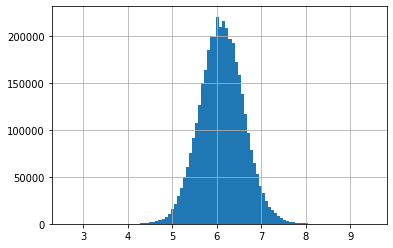

In [97]:
top_22_data_df['target_area_log'].hist(bins=100)